In [1]:
import torch_geometric as tg
import torch 
from utils.data import build_data, get_target, get_neighbors
from utils.training import get_model, train

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
def cal_mae_rmse_r2(dft_val,pred):
    mae = mean_absolute_error(dft_val,pred)
    rmse = mean_squared_error(dft_val,pred,squared=False)
    r2 = r2_score(dft_val,pred)
    return mae, rmse, r2

def add_metrics(title,mae,r2,ax,rmse,unit,test=True,fontsize=12):
    if test:
        ha = 'left'
        va = 'top'    
        lp = 0.04
        start = .98
    else:
        ha = 'left'
        va =  'bottom'
        lp = .38
        start = .16
    ax.text(lp, start, title, horizontalalignment=ha,verticalalignment=va,transform = ax.transAxes, 
            fontsize=fontsize)
    ax.text(lp, start, "_____________", horizontalalignment=ha,verticalalignment=va,transform = ax.transAxes,
           fontsize=fontsize)
    ax.text(lp, start-.07, str("R"+r"$^2$: "+f"   {r2:.2f}"), horizontalalignment=ha,verticalalignment=va,transform = ax.transAxes,
           fontsize=fontsize)
    ax.text(lp, start-.15, str(f"MAE: {mae:.2f} {unit}"), horizontalalignment=ha,verticalalignment=va,transform = ax.transAxes,
           fontsize=fontsize)
    ax.text(lp, start-.22, str(f"RMSE: {rmse:.2f} {unit}"), horizontalalignment=ha,verticalalignment=va,transform = ax.transAxes,
           fontsize=fontsize)
    
    
def cal_lamb(freq_w,alpha_F):
    lambdaF = 0
    try:
        for i in range(1,len(freq_w)):
            dw = freq_w[i] - freq_w[i-1]
            w = freq_w[i]
            alpha_F_w = alpha_F[i]
            lambdaF = lambdaF + ((alpha_F_w/w)*dw)
        return 2*lambdaF
    except:
        return np.nan

def cal_w_log(freq_w,alpha_F,lamb):
    w_logF = 0
    try:
        for i in range(1,len(freq_w)):
            dw = freq_w[i] - freq_w[i-1]
            w_logF = w_logF + (alpha_F[i]*np.log(freq_w[i])*dw/freq_w[i])
        return np.exp(2*w_logF/lamb)
    except: 
        return np.nan

def cal_w_sq(freq_w,alpha_F,lamb):
    w_sqF = 0
    try:
        for i in range(1,len(freq_w)):
            dw = freq_w[i] - freq_w[i-1]
            w_sqF = w_sqF + (alpha_F[i]*freq_w[i]*dw)
        return (2*w_sqF/lamb)**.5
    except:
        return np.nan

def cal_tc(lamb, omega_log,mu=0.09):
    frac = -1.04*(1+lamb)/(lamb-mu*(1+0.62*lamb))
    return (omega_log/1.2)*np.exp(frac)

def get_avg(df):
    pred = np.zeros(51)
    for i in folds:
        pred += df[f'pred_{i}']
    return pred/len(folds)

def get_lamb(df):
    return cal_lamb(Freq_final,df.pred_avg)

def get_w2(df):
    return cal_w_sq(Freq_final,df.pred_avg,df.lamb_pred)/0.08617

def get_wlog(df):
    return cal_w_log(Freq_final,df.pred_avg,df.lamb_pred)/0.08617

def get_lamb_target(df):
    return cal_lamb(Freq_final,df.target)

def get_w2_target(df):
    return cal_w_sq(Freq_final,df.target,df.lamb_target)/0.08617

def get_wlog_target(df):
    return cal_w_log(Freq_final,df.target,df.lamb_target)/0.08617

def get_diff_lamb(df):
    return abs(df.lamb_pred-df.lamb_target)

def get_diff_w2(df):    
    return abs(df.w2_pred-df.w2_target)

def get_diff_wlog(df):
    return abs(df.wlog_pred-df.wlog_target)

def get_avg_diff(df):
    lamb = (df.diff_lamb - min_lamb)/(max_lamb-min_lamb)
    w2 = (df.diff_w2 - min_w2)/(max_w2-min_w2)
    wlog = (df.diff_wlog - min_wlog)/(max_wlog-min_wlog)
    return (lamb+w2+wlog)/3

def convert_to_subscript(s):
    """
    Converts numbers in a string to subscript format for use in matplotlib axes title.
    
    Args:
    s (str): The input string with numbers.

    Returns:
    str: The string with numbers converted to subscript.
    """
    # Create a mapping for subscript characters
    subscript_map = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

    # Translate the string using the subscript map
    return s.translate(subscript_map)

def convert_to_subscript(s):
    """
    Converts numbers in a string to LaTeX subscript format.
    
    Args:
    s (str): The input string with numbers.

    Returns:
    str: The string in LaTeX format with numbers as subscripts.
    """
    result = ""

    # Iterate through each character in the string
    for char in s:
        # If the character is a digit, add it as a subscript
        if char.isdigit():
            result += "$\mathrm{_{" + char + "}}$"
        else:
            # If not a digit, just add the character as it is
            result += char

    return  result #+ r'}$'

In [3]:
data_path = 'database.pkl'
df = pd.read_pickle(data_path)
df.dropna(inplace=True)

In [4]:
Freq_final =np.arange(0.25,101,2)
Freq_final_E =np.arange(-50,50,1)

In [5]:
r_max = 4
df['target'] = df.apply(get_target,axis=1)
df['formula'] = df['structure'].map(lambda x: x.get_chemical_formula())
df['species'] = df['structure'].map(lambda x: list(set(x.get_chemical_symbols())))
species = sorted(list(set(df['species'].sum())))

df['data'] = df.apply(build_data,embed_ph_dos=True,embed_e_dos=False,fine=True,r_max = r_max,axis=1)


In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

out_dim = len(df.iloc[0]['target'])
in_dim = len(df.iloc[0].data.x[0])
em_dim = 64

In [10]:
init_dict_base = dict(in_dim=118+51,                           
    em_dim=em_dim,                        
    irreps_in=str(em_dim)+"x0e",          
    irreps_out=str(out_dim)+"x0e",        
    irreps_node_attr=str(em_dim)+"x0e",   
    layers=2,                             
    mul=32,                               
    lmax=1,                               
    max_radius=r_max,      
    num_neighbors=get_neighbors(df,df.index).mean(),      
    reduce_output=True,
    p=0.0
)

In [8]:
dataloader = tg.loader.DataLoader(df['data'].values, batch_size=900)

In [9]:
folds =range(10)

In [12]:
for k in tqdm(folds):
    name = f"FPD_{k}.pt"
    run_name = f'final_models/{name}'

    model, opt, scheduler = get_model(init_dict_base,device=device)
    model.load_state_dict(torch.load(run_name))
    model.pool = True

    df[f'pred_{k}'] = np.empty((len(df), 1)).tolist()

    model.to(device)
    model.eval()
    with torch.no_grad():
        i0 = 0
        for i, d in enumerate(dataloader):
            d.to(device)
            output = model(d)
            df[f'pred_{k}']= [k for k in output.cpu().numpy()]
#             i0 += len(d.target)


100%|████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.58s/it]


In [13]:
tqdm.pandas()
df['pred_avg'] = df.progress_apply(get_avg,axis=1)
df['lamb_pred'] = df.progress_apply(get_lamb,axis=1)
df['w2_pred'] = df.progress_apply(get_w2,axis=1)
df['wlog_pred'] = df.progress_apply(get_wlog,axis=1)

df['lamb_target'] = df.progress_apply(get_lamb_target,axis=1)
df['w2_target'] = df.progress_apply(get_w2_target,axis=1)
df['wlog_target'] = df.progress_apply(get_wlog_target,axis=1)

100%|████████████████████████████████████████████████████████████| 806/806 [00:00<00:00, 9382.76it/s]


In [14]:
idx_test = np.loadtxt('indices/idx_valid_final.txt')
idx_test = df.loc[df.index.isin(idx_test)].index

Text(0.5, 0, 'Target')

<Figure size 640x480 with 0 Axes>

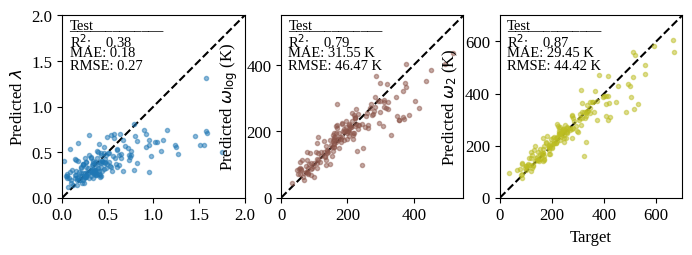

In [15]:
fontsize = 12

plt.clf()
plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = 'Liberation Serif'#"Times New Roman"

plt.subplots_adjust(left=0.05,bottom=0.07,right=0.99,top=0.99)
fig, axs = plt.subplots(1,3,figsize=(8,8))

prop = ['lamb','wlog','w2']
color = ['C0','C5','C8']
units = ['','K','K']

for i in range(3):
    if i==0:
        lim = (0,2)
        ticks = [0,0.5,1.0,1.5,2.0]

    if i==1:
        lim = (0,550)
        ticks = np.arange(0,600,200)
    if i==2:
        lim = (0,700)
        ticks = np.arange(0,800,200)

    axs[i].scatter(df.loc[idx_test][prop[i]+'_target'], df.loc[idx_test][prop[i]+'_pred'],
                     marker='.',color=color[i],alpha=0.5)

    axs[i].plot(lim,lim,'k--',zorder=0)
    axs[i].set_xlim(lim)
    axs[i].set_ylim(lim)
    axs[i].set_xticks(ticks)
    axs[i].set_yticks(ticks)
    axs[i].set_aspect('equal')
        
    mae, rmse, r2 = cal_mae_rmse_r2(dft_val=df.loc[idx_test][prop[i]+'_target'], 
                                    pred=df.loc[idx_test][prop[i]+'_pred'])
    add_metrics(title='Test',mae=mae,r2=r2,
                ax=axs[i],rmse=rmse,unit=units[i],test=True, fontsize=10.5)
        
        
axs[0].set_ylabel(r'Predicted $\lambda$')
axs[1].set_ylabel(r'Predicted $\omega_{\text{log}}$ (K)')
axs[2].set_ylabel(r'Predicted $\omega_{2}$ (K)')

axs[2].set_xlabel('Target')


In [16]:
df['diff_lamb'] = df.apply(get_diff_lamb,axis = 1)
df['diff_w2'] = df.apply(get_diff_w2,axis = 1)
df['diff_wlog'] = df.apply(get_diff_wlog,axis = 1)

min_lamb = df.diff_lamb.min()
min_w2 = df.diff_w2.min()
min_wlog = df.diff_wlog.min()

max_lamb = df.diff_lamb.max()
max_w2 = df.diff_w2.max()
max_wlog = df.diff_wlog.max()

df['diffs'] = df.apply(get_avg_diff,axis = 1)
df.sort_values(by='diffs',inplace=True,ascending=True)

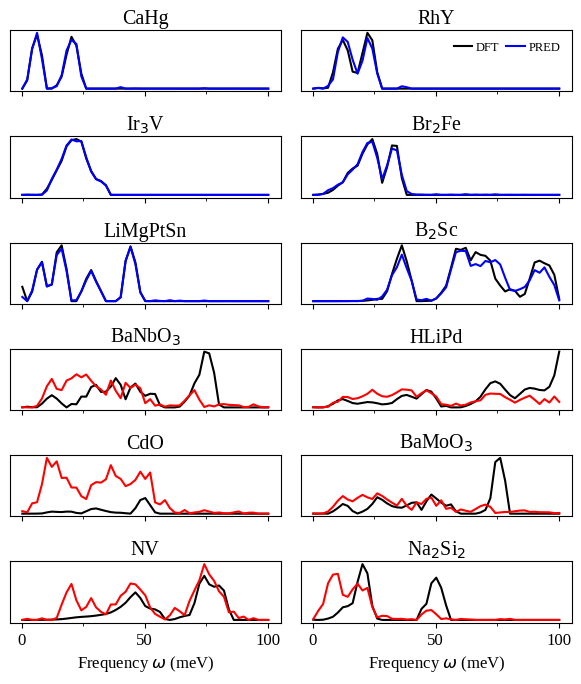

In [17]:
fig, axs = plt.subplot_mosaic([['b0','b1'],['b2','b3'],
                               ['b4','b5'],['w0','w1'],
                              ['w2','w3'],['w4','w5']],figsize=(6,7))
y=.97
for i,idx in enumerate(df.head(6).index):
    axs[f'b{i}'].plot(Freq_final,df.loc[idx].target,'k',label='DFT')

    axs[f'b{i}'].plot(Freq_final,df.loc[idx].pred_avg,'b',label='PRED')
    axs[f'b{i}'].set_title(convert_to_subscript(df.loc[idx].comp),y=y)
for i,idx in enumerate(df.tail(6).index):
    
    axs[f'w{i}'].plot(Freq_final,df.loc[idx].target,'k')

    axs[f'w{i}'].plot(Freq_final,df.loc[idx].pred_avg,'r')
    axs[f'w{i}'].set_title(convert_to_subscript(df.loc[idx].comp),y=y)
for c in ['w','b']:   
    for i in range(6):
        axs[f'{c}{i}'].set_xticks([0,50,100])
        axs[f'{c}{i}'].set_xticks([25,75],minor=True)
        axs[f'{c}{i}'].set_yticks([])
        axs[f'{c}{i}'].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False) 
#         axs[f'{c}{i}'].tick_params(axis='y', which='both', bottom=True, top=False, labelbottom=False)    
    
    
axs[f'w5'].set_xlabel('Frequency '+r'$\omega$ (meV)')    
axs[f'w5'].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[f'w4'].set_xlabel('Frequency '+r'$\omega$ (meV)')    
axs[f'w4'].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

axs['b1'].legend(ncols=2,fontsize=9,handletextpad=.3,columnspacing=.5,handlelength=1.5,frameon=False)
plt.tight_layout()